In [1]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379/code
# for of sub23, change model + 5 folds

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")
SIZE = 299

In [3]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric/notebook
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + (1 - K.mean(f1))

In [4]:
# Load dataset info
path_to_train = '../data/train/'
data = pd.read_csv('../data/train.csv')

In [5]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [7]:
train_dataset_info

array([{'path': '../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '../data/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '../data/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '../data/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '../data/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '../data/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

In [8]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment2(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
        zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_yellow_ch),
#             zero_data, zero_data), -1)
#         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2))
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug
    def augment2(image):
        augment_img = iaa.Sequential([
            iaa.SomeOf((0,5),[
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug


In [9]:
%matplotlib inline

In [10]:
img = data_generator.load_image(train_dataset_info[0]['path'], (SIZE, SIZE, 3))

In [11]:
img.shape

(299, 299, 3)

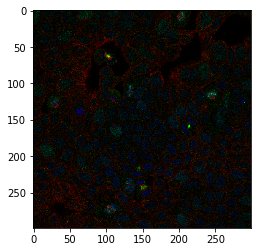

In [12]:
plt.imshow(img)

In [13]:
img2 = data_generator.augment(img)

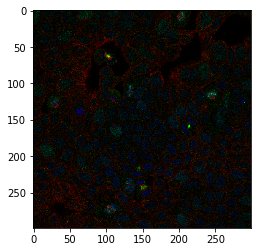

In [14]:
plt.imshow(img2)

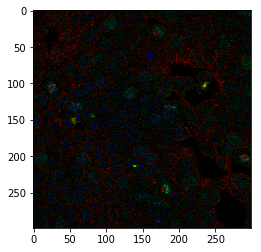

In [15]:
img2 = data_generator.augment2(img)
plt.imshow(img2)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

Using TensorFlow backend.


In [17]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
#     x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [18]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

# https://github.com/ailias/Focal-Loss-implement-on-Tensorflow/blob/master/focal_loss.py
def focal_loss_org(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)


In [19]:
def focal_loss(weights=None, alpha=0.25, gamma=2):
    def focal_loss_my(target_tensor, prediction_tensor, ):
        r"""Compute focal loss for predictions.
            Multi-labels Focal loss formula:
                FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                     ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
        Args:
         prediction_tensor: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing the predicted logits for each class
         target_tensor: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing one-hot encoded classification targets
         weights: A float tensor of shape [batch_size, num_anchors]
         alpha: A scalar tensor for focal loss alpha hyper-parameter
         gamma: A scalar tensor for focal loss gamma hyper-parameter
        Returns:
            loss: A (scalar) tensor representing the value of the loss function
        """
        sigmoid_p = tf.nn.sigmoid(prediction_tensor)
        zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)

        # For poitive prediction, only need consider front part loss, back part is 0;
        # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
        pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)

        # For negative prediction, only need consider back part loss, front part is 0;
        # target_tensor > zeros <=> z=1, so negative coefficient = 0.
        neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
        per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                              - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
        return tf.reduce_sum(per_entry_cross_ent)
#         return K.mean(K.binary_crossentropy(target_tensor, prediction_tensor), axis=-1) + tf.reduce_sum(per_entry_cross_ent)
    return focal_loss_my

In [20]:
def focal_loss_fixed(y_true, y_pred):
    gamma = 2.
    alpha = 0.25
    print(y_pred)
    print(y_true)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#     pt_1 = K.clip(pt_1, 1e-3, .999)
#     pt_0 = K.clip(pt_0, 1e-3, .999)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [21]:
# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#         pt_1 = K.clip(pt_1, 1e-3, .999)
#         pt_0 = K.clip(pt_0, 1e-3, .999)

#         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [22]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



In [23]:
train_dataset_info.shape

(31072,)

In [24]:

# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
# np.random.shuffle(indexes)
# train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
submit = pd.read_csv('../data/sample_submission.csv')

# train_generator = data_generator.create_train(
#     train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
# validation_generator = data_generator.create_train(
#     train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

# oof_class_preds = np.zeros((train_dataset_info.shape[0], 28))
# sub_class_preds = np.zeros((submit.shape[0], 28))

oof_class_preds = np.load('../cache/oof_class_preds-32.npy')
sub_class_preds = np.load('../cache/sub_class_preds-32.npy')

fold_ = 0
epochs = 10; batch_size = 16
for train_indexes, valid_indexes in kf.split(indexes):
    if fold_ < 4:
        fold_ += 1
        continue
    chk_name = '../cache/InceptionV3-32-{}.h5'.format(fold_)
    checkpoint = ModelCheckpoint(chk_name, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', save_weights_only = True)
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                       verbose=1, mode='auto', epsilon=0.0001)
    early = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=6)
    callbacks_list = [checkpoint, early, reduceLROnPlat]


    _preds = []
    # create train and valid datagens
    train_generator = data_generator.create_train(
        train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
    validation_generator = data_generator.create_train(
        train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=True)

    # warm up model
    model = create_model(
        input_shape=(SIZE,SIZE,3), 
        n_out=28)
    
    # train all layers
    epochs=120
    for layer in model.layers:
        layer.trainable = True
    model.compile(loss=f1_loss,
                optimizer=Adam(lr=1e-4),
                metrics=[f1])
    model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
        validation_data=validation_generator,
        validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
        epochs=epochs, 
        verbose=1,
        callbacks=callbacks_list)
    
    model_name = '../cache/my_model_weights-32-{}.h5'.format(fold_)
    model.save_weights(model_name)
    model.load_weights(chk_name)
    for idx in tqdm(valid_indexes):
        item = train_dataset_info[idx]
        path = item['path']
        labels = item['labels']
        image = data_generator.load_image(path, (SIZE,SIZE,3))
        image = data_generator.augment2(image)
        image = image / 255.
        score_predict = model.predict(image[np.newaxis])[0]
        oof_class_preds[idx] = score_predict
        np.save('../cache/oof_class_preds-32.npy', oof_class_preds)
        
    for idx, name in tqdm(enumerate(submit['Id'])):
        path = os.path.join('../data/test/', name)
        image = data_generator.load_image(path, (SIZE,SIZE,3))
        image = data_generator.augment2(image)
        image = image / 255.
        score_predict = model.predict(image[np.newaxis])[0]
        sub_class_preds[idx] += score_predict
        np.save('../cache/sub_class_preds-32.npy', sub_class_preds)
    fold_ += 1
sub_class_preds /= n_splits

Epoch 1/120
1554/1554 [==============================] - 569s 366ms/step - loss: 1.0254 - f1: 0.1446 - val_loss: 0.8960 - val_f1: 0.2508

Epoch 00001: val_loss improved from inf to 0.89595, saving model to ../cache/InceptionV3-32-4.h5
Epoch 2/120
1554/1554 [==============================] - 546s 351ms/step - loss: 0.9217 - f1: 0.2215 - val_loss: 0.9109 - val_f1: 0.2401

Epoch 00002: val_loss did not improve from 0.89595
Epoch 3/120
1554/1554 [==============================] - 553s 356ms/step - loss: 0.8909 - f1: 0.2428 - val_loss: 0.8687 - val_f1: 0.2679

Epoch 00003: val_loss improved from 0.89595 to 0.86869, saving model to ../cache/InceptionV3-32-4.h5
Epoch 4/120
1554/1554 [==============================] - 537s 345ms/step - loss: 0.8733 - f1: 0.2534 - val_loss: 0.8183 - val_f1: 0.3127

Epoch 00004: val_loss improved from 0.86869 to 0.81826, saving model to ../cache/InceptionV3-32-4.h5
Epoch 5/120
1554/1554 [==============================] - 536s 345ms/step - loss: 0.8582 - f1: 0.26

100%|██████████| 6214/6214 [05:57<00:00, 17.37it/s]
11702it [08:49, 22.11it/s]


In [25]:
# for idx in tqdm(valid_indexes):
#     item = train_dataset_info[idx]
#     path = item['path']
#     labels = item['labels']
#     image = data_generator.load_image(path, (SIZE,SIZE,3))
#     image = data_generator.augment(image)
#     image = image / 255.
#     score_predict = model.predict(image[np.newaxis])[0]
#     oof_class_preds[idx] = score_predict
#     np.save('../cache/oof_class_preds-20.npy', oof_class_preds)
        

In [26]:
np.save('../cache/oof_class_preds-23-1.npy', oof_class_preds)
np.save('../cache/sub_class_preds-23-1.npy', sub_class_preds)

In [27]:
np.save('../cache/oof_class_preds-32-1.npy', oof_class_preds)
np.save('../cache/sub_class_preds-32-1.npy', sub_class_preds)

In [28]:
# oof_class_preds = np.zeros((train_dataset_info.shape[0], 28))
# sub_class_preds = np.zeros((submit.shape[0], 28))
# score_predict = model.predict(image[np.newaxis])[0]
# oof_class_preds[idx] = score_predict

In [29]:
# for train_index, test_index in kf.split(indexes):
# ...    print("TRAIN:", train_index, "TEST:", test_index)

In [30]:
sub_class_preds.shape

(11702, 28)

In [31]:
predicted = []
for line in tqdm(sub_class_preds):
    label_predict = np.arange(28)[line>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [00:00<00:00, 111938.66it/s]


In [32]:
len(predicted)

11702

In [33]:
predicted

['2',
 '5',
 '0 5 25',
 '0',
 '25',
 '4',
 '4 25',
 '0 25',
 '0',
 '25',
 '18 25',
 '3 5',
 '25',
 '',
 '23',
 '4',
 '2 14',
 '0 5',
 '14 21',
 '5',
 '6',
 '3 5',
 '0',
 '0',
 '0',
 '12 25',
 '0',
 '0',
 '0 25',
 '0',
 '21',
 '0',
 '17 18',
 '5',
 '0 7',
 '13',
 '',
 '0 3',
 '0 21',
 '1',
 '0 25',
 '25',
 '0',
 '19 25',
 '',
 '6',
 '0',
 '',
 '',
 '0',
 '0 25',
 '0 5',
 '',
 '25',
 '3',
 '0 25',
 '0 25',
 '',
 '0 25',
 '21 25',
 '2',
 '0 5',
 '14',
 '',
 '23',
 '0 25',
 '3 25',
 '',
 '0',
 '21',
 '2',
 '0 2',
 '14',
 '4',
 '21',
 '0',
 '4',
 '0 1',
 '0 25',
 '0',
 '',
 '0 25',
 '0 21',
 '21 25',
 '18',
 '0',
 '23',
 '0 21',
 '25',
 '14',
 '25',
 '',
 '23',
 '13',
 '16 17 25',
 '0 25',
 '18 25',
 '0 7',
 '24',
 '25',
 '0 25',
 '23',
 '21',
 '0 23',
 '7',
 '19 21 25',
 '0 14 16',
 '0 24',
 '20 26',
 '0',
 '2',
 '1',
 '17 25',
 '0 22',
 '25',
 '23',
 '0',
 '4',
 '25',
 '26',
 '0 18 19 25',
 '21',
 '2 21',
 '20',
 '4',
 '0',
 '0 25',
 '25',
 '0 4',
 '19',
 '25',
 '0 21',
 '0',
 '0',
 '0 11

In [34]:
submit['Predicted'] = predicted

In [35]:
# Create submit
# submit = pd.read_csv('../data/sample_submission.csv')
# predicted = []
# draw_predict = []
# # model.load_weights('../cache/InceptionV3.h5')
# for name in tqdm(submit['Id']):
#     path = os.path.join('../data/test/', name)
#     image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
#     score_predict = model.predict(image[np.newaxis])[0]
#     draw_predict.append(score_predict)
#     label_predict = np.arange(28)[score_predict>=0.2]
#     str_predict_label = ' '.join(str(l) for l in label_predict)
#     predicted.append(str_predict_label)

# submit['Predicted'] = predicted
# np.save('../cache/draw_predict_InceptionV3-8.npy', score_predict)
# submit.to_csv('../submissions/submit_InceptionV3.csv', index=False)

In [36]:
submit.to_csv('../submissions/sub32-a.csv', index=False)

In [37]:
#https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory
def backup_project_as_zip(project_dir, zip_file):
    assert(os.path.isdir(project_dir))
    assert(os.path.isdir(os.path.dirname(zip_file)))
    shutil.make_archive(zip_file.replace('.zip',''), 'zip', project_dir)
    pass

In [38]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-11-15 17:12:46.387453


In [39]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub32-a.csv -m ""

100%|████████████████████████████████████████| 465k/465k [00:12<00:00, 37.1kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 383 ms, sys: 128 ms, total: 510 ms
Wall time: 15.8 s


In [40]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub32-a.csv   2018-11-15 11:43:12               complete  0.449        None          
sub8f-1.csv   2018-11-14 12:36:46               complete  0.398        None          
sub8j.csv     2018-11-14 08:48:31               complete  0.063        None          
sub8i.csv     2018-11-14 04:28:35               complete  0.443        None          
sub8h.csv     2018-11-13 23:48:00               complete  0.434        None          
sub8g.csv     2018-11-13 07:17:59               complete  0.389        None          
sub8c.csv     2018-11-11 14:31:02               complete  0.429        None          
sub30.csv     2018-11-09 07:02:56               complete  0.033        None          
sub29.csv     2018-11-08 22:07:11               complete  0.389        None          
sub28-c.csv   2018-11-08 15:47:08               comple

In [41]:
predicted = []
for line in tqdm(sub_class_preds):
    label_predict = np.arange(28)[line>=0.45]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [00:00<00:00, 123993.27it/s]


In [42]:
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub32-b.csv', index=False)

In [43]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-11-15 17:14:16.717746


In [44]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub32-b.csv -m ""

100%|████████████████████████████████████████| 467k/467k [00:12<00:00, 37.0kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 345 ms, sys: 194 ms, total: 538 ms
Wall time: 16.4 s


In [45]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub32-b.csv   2018-11-15 11:44:43               complete  0.456        None          
sub32-a.csv   2018-11-15 11:43:12               complete  0.449        None          
sub8f-1.csv   2018-11-14 12:36:46               complete  0.398        None          
sub8j.csv     2018-11-14 08:48:31               complete  0.063        None          
sub8i.csv     2018-11-14 04:28:35               complete  0.443        None          
sub8h.csv     2018-11-13 23:48:00               complete  0.434        None          
sub8g.csv     2018-11-13 07:17:59               complete  0.389        None          
sub8c.csv     2018-11-11 14:31:02               complete  0.429        None          
sub30.csv     2018-11-09 07:02:56               complete  0.033        None          
sub29.csv     2018-11-08 22:07:11               comple

In [46]:
d = {0.4:'bb', 0.35:'c', 0.3:'d', 0.25:'e', 0.2:'f'}

In [47]:
for alpha in [0.4, 0.35, 0.3, 0.25, 0.2]:
    predicted = []
    for line in tqdm(sub_class_preds):
        label_predict = np.arange(28)[line>=alpha]
        str_predict_label = ' '.join(str(l) for l in label_predict)
        predicted.append(str_predict_label)
    submit['Predicted'] = predicted
    name = '../submissions/sub32-' + d[alpha] + '.csv'
    print(name)
    submit.to_csv(name, index=False)

  0%|          | 0/11702 [00:00<?, ?it/s]

../submissions/sub32-bb.csv
../submissions/sub32-c.csv


  0%|          | 0/11702 [00:00<?, ?it/s]

../submissions/sub32-d.csv
../submissions/sub32-e.csv


100%|██████████| 11702/11702 [00:00<00:00, 125247.83it/s]

../submissions/sub32-f.csv


In [48]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub32-bb.csv -m ""

100%|████████████████████████████████████████| 470k/470k [00:12<00:00, 39.5kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 357 ms, sys: 142 ms, total: 500 ms
Wall time: 15.2 s


In [49]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub32-bb.csv  2018-11-15 11:46:01               complete  0.465        None          
sub32-b.csv   2018-11-15 11:44:43               complete  0.456        None          
sub32-a.csv   2018-11-15 11:43:12               complete  0.449        None          
sub8f-1.csv   2018-11-14 12:36:46               complete  0.398        None          
sub8j.csv     2018-11-14 08:48:31               complete  0.063        None          
sub8i.csv     2018-11-14 04:28:35               complete  0.443        None          
sub8h.csv     2018-11-13 23:48:00               complete  0.434        None          
sub8g.csv     2018-11-13 07:17:59               complete  0.389        None          
sub8c.csv     2018-11-11 14:31:02               complete  0.429        None          
sub30.csv     2018-11-09 07:02:56               comple

In [50]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub32-c.csv -m ""
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 473k/473k [00:08<00:00, 40.4kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub32-c.csv   2018-11-15 11:47:19               complete  0.463        None          
sub32-bb.csv  2018-11-15 11:46:01               complete  0.465        None          
sub32-b.csv   2018-11-15 11:44:43               complete  0.456        None          
sub32-a.csv   2018-11-15 11:43:12               complete  0.449        None          
sub8f-1.csv   2018-11-14 12:36:46               complete  0.398        None          
sub8j.csv     2018-11-14 08:48:31               complete  0.063        None          
sub8i.csv     2018-11-14 04:28:35               complete  0.443        None          
sub8h.csv     2018-11-13 23:48:00               complete  0.434        None    

In [1]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub23-d.csv -m ""
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 481k/481k [00:13<00:00, 36.6kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub23-d.csv   2018-11-07 00:21:06               complete  0.469        None          
sub23-c.csv   2018-11-06 14:34:37               complete  0.472        None          
sub23-bb.csv  2018-11-06 14:33:35               complete  0.466        None          
sub23-b.csv   2018-11-06 14:32:47               complete  0.463        None          
sub23-a.csv   2018-11-06 14:31:57               complete  0.461        None          
sub22-a.csv   2018-11-06 14:30:53               complete  0.467        None          
sub22-b.csv   2018-11-05 16:50:03               complete  0.467        None          
sub22-a.csv   2018-11-05 16:48:26               complete  0.467        None    

In [ ]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub21-e.csv -m ""
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

In [ ]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub21-f.csv -m ""
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

In [46]:
oof_class_preds.shape

(31072, 28)

In [47]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [48]:
data.shape

(31072, 2)

In [49]:
n_classes = 28
y_train = np.zeros(oof_class_preds.shape)
y_train.shape

(31072, 28)

In [50]:
idx = 0
for labels in tqdm(data['Target'].str.split(' ')):
#     print(labels)
    for label in labels:
        y_train[idx][int(label)] = 1
    idx += 1

100%|██████████| 31072/31072 [00:00<00:00, 741901.66it/s]


In [51]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [52]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
sub_ridge_preds = np.zeros(sub_class_preds.shape)
from sklearn.linear_model import Ridge
for cls in np.arange(n_classes):
    for alpha in [0.001, 0.01, 0.1, 0.5, 0.75, 1.0]:
        y = y_train[:, cls]
        X = oof_class_preds
        clf = Ridge(alpha=alpha)
        clf.fit(X,y)
        score_ = clf.score(X, y)
        print(alpha, score_)
    print('------------------')
#         X_test = sub_class_preds[:, cls]
#         preds_ = clf.predict(X_test)
#         sub_ridge_preds[:,cls] = preds_

0.001 0.6174081518752018
0.01 0.6174081494907646
0.1 0.6174079419635514
0.5 0.6174049197331472
0.75 0.6174023910597577
1.0 0.6173997536697944
------------------
0.001 0.7042131450176463
0.01 0.7042131449021258
0.1 0.7042131341504188
0.5 0.7042129258072632
0.75 0.7042126913081677
1.0 0.7042123865546952
------------------
0.001 0.6405293650278552
0.01 0.6405293643199262
0.1 0.6405293035770623
0.5 0.6405284696126301
0.75 0.6405278129689744
1.0 0.6405271539313317
------------------
0.001 0.5206868082561187
0.01 0.5206868064937693
0.1 0.5206866550090807
0.5 0.5206845661735036
0.75 0.5206829204240566
1.0 0.5206812723936773
------------------
0.001 0.6225629182679313
0.01 0.6225628870674288
0.1 0.6225602493284829
0.5 0.6225265347174933
0.75 0.6225024258166685
1.0 0.6224802007531789
------------------
0.001 0.47625033808763034
0.01 0.4762503310360723
0.1 0.47624973372408597
0.5 0.4762420258070793
0.75 0.4762364393569697
1.0 0.47623122503579396
------------------
0.001 0.37015383088158105
0.01 

In [55]:
sub_ridge_preds = np.zeros(sub_class_preds.shape)
from sklearn.linear_model import Ridge
for cls in np.arange(n_classes):
    y = y_train[:, cls]
    X = oof_class_preds
    clf = Ridge(alpha=0.1)
    clf.fit(X,y)
    X_test = sub_class_preds
    preds_ = clf.predict(X_test)
    sub_ridge_preds[:,cls] = preds_

In [56]:
sub_class_preds

array([[9.38001867e-02, 1.59430779e-04, 9.98871672e-01, ...,
        1.77784316e-03, 1.12266340e-04, 5.20836841e-09],
       [2.47062426e-02, 2.68127583e-04, 7.85995722e-04, ...,
        6.51888692e-01, 8.71524611e-04, 3.26655725e-05],
       [8.41529155e-01, 2.72278007e-04, 3.96186303e-03, ...,
        9.23864961e-01, 2.01543609e-03, 1.92988443e-05],
       ...,
       [6.59056642e-04, 5.12143007e-05, 3.49444263e-05, ...,
        1.77463120e-03, 5.20864920e-08, 5.91902866e-09],
       [5.01914832e-01, 9.99162483e-01, 2.73049554e-03, ...,
        1.16331837e-02, 1.53418808e-04, 1.20560289e-06],
       [5.07521251e-01, 3.52088286e-04, 3.01849514e-03, ...,
        6.92711103e-01, 1.99362053e-03, 1.05607675e-06]])

In [57]:
np.arange(n_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [58]:
sub_class_preds[:, 0].shape

(11702,)

In [59]:
sub_ridge_preds

array([[ 1.26424064e-01,  8.84581981e-03,  8.85833838e-01, ...,
         3.20592330e-02,  4.54385428e-03, -6.92529375e-05],
       [ 5.51528260e-02,  2.13827355e-03,  1.63897473e-02, ...,
         5.38178358e-01,  1.06812025e-03,  1.39571143e-03],
       [ 7.77233272e-01, -1.67743788e-03,  1.87791802e-02, ...,
         7.51411388e-01, -1.45306321e-03,  1.27131495e-03],
       ...,
       [ 2.62432560e-02,  4.66381707e-04,  7.97892029e-03, ...,
         2.92185935e-02,  3.12140745e-03,  1.76712611e-04],
       [ 4.95625470e-01,  8.71181686e-01,  1.99755452e-02, ...,
         3.70837162e-02,  3.03441473e-03,  3.03600332e-05],
       [ 4.96285545e-01,  1.04218405e-02,  2.67882221e-02, ...,
         5.85205684e-01,  4.37290352e-03,  1.52204091e-06]])

In [60]:
predicted = []
alpha = 0.35
for line in tqdm(sub_ridge_preds):
    label_predict = np.arange(28)[line>=alpha]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
name = '../submissions/sub12-g.csv'
print(name)
submit.to_csv(name, index=False)

100%|██████████| 11702/11702 [00:00<00:00, 88242.24it/s]

../submissions/sub12-g.csv


In [61]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub12-g.csv -m ""

Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 372 ms, sys: 201 ms, total: 573 ms
Wall time: 17.3 s


In [62]:
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub12-g.csv   2018-10-25 00:55:10               complete  0.433        None          
sub12-c.csv   2018-10-25 00:45:32               complete  0.469        None          
sub12-bb.csv  2018-10-25 00:43:34               complete  0.466        None          
sub12-b.csv   2018-10-25 00:41:50               complete  0.457        None          
sub12-a.csv   2018-10-25 00:40:56               complete  0.449        None          
sub11-k.csv   2018-10-24 00:35:39               complete  0.346        None          
sub11-j.csv   2018-10-24 00:34:46               complete  0.366        None          
sub11-j.csv   2018-10-24 00:33:17               complete  0.000        None          
sub11-i.csv   2018-10-24 00:24:24               complete  0.389        None          
sub11-h.csv   2018-10-24 00:21:18               comple

In [63]:
predicted = []
alpha = 0.4
for line in tqdm(sub_ridge_preds):
    label_predict = np.arange(28)[line>=alpha]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
name = '../submissions/sub12-h.csv'
print(name)
submit.to_csv(name, index=False)

100%|██████████| 11702/11702 [00:00<00:00, 79991.76it/s]

../submissions/sub12-h.csv


In [64]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub12-h.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

Successfully submitted to Human Protein Atlas Image ClassificationWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.0 / client 1.3.8)
fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub12-h.csv   2018-10-26 02:07:56               complete  0.389        None          
sub12-g.csv   2018-10-25 00:55:10               complete  0.433        None          
sub12-c.csv   2018-10-25 00:45:32               complete  0.469        None          
sub12-bb.csv  2018-10-25 00:43:34               complete  0.466        None          
sub12-b.csv   2018-10-25 00:41:50               complete  0.457        None          
sub12-a.csv   2018-10-25 00:40:56               complete  0.449        None          
sub11-k.csv   2018-10-24 00:35:39               complete  0.346        None          
sub11-j.csv   2018-10-24 00:34:46              

In [65]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub12-d.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

Successfully submitted to Human Protein Atlas Image ClassificationWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.0 / client 1.3.8)
fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub12-d.csv   2018-10-26 02:09:32               complete  0.466        None          
sub12-h.csv   2018-10-26 02:07:56               complete  0.389        None          
sub12-g.csv   2018-10-25 00:55:10               complete  0.433        None          
sub12-c.csv   2018-10-25 00:45:32               complete  0.469        None          
sub12-bb.csv  2018-10-25 00:43:34               complete  0.466        None          
sub12-b.csv   2018-10-25 00:41:50               complete  0.457        None          
sub12-a.csv   2018-10-25 00:40:56               complete  0.449        None          
sub11-k.csv   2018-10-24 00:35:39              